<a href="https://colab.research.google.com/github/suucong/AI_Practice/blob/main/autoincoder_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
# 하이퍼파라미터
batch_size = 256
learning_rate = 0.0002
num_epoch = 10

In [3]:
# 데이터 다운로드
mnist_train = dset.MNIST(root="../", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST(root="../", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 28606714.29it/s]


Extracting ../MNIST/raw/train-images-idx3-ubyte.gz to ../MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 41286875.88it/s]


Extracting ../MNIST/raw/train-labels-idx1-ubyte.gz to ../MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 42772007.25it/s]

Extracting ../MNIST/raw/t10k-images-idx3-ubyte.gz to ../MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 7006446.77it/s]


Extracting ../MNIST/raw/t10k-labels-idx1-ubyte.gz to ../MNIST/raw



In [4]:
# DataLoader 설정
train_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

In [5]:
# 모델 선언
# 인공신경망으로 이루어진 오토인코더를 생성
# 단순하게 하기 위해 활성화 함수 생략
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # 2. Encoder와 Decoder에 각각 1개의 layer 추가 및 노드 수 변경
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 256),  # Additional layer with 256 nodes in the hidden layer
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(batch_size, -1)
        encoded = self.encoder(x)
        out = self.decoder(encoded).view(batch_size, 1, 28, 28)
        return out

In [6]:
# 손실 함수, 최적화 함수
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = Autoencoder().to(device)
loss_func = nn.MSELoss()  # 인스턴스를 생성
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cuda:0


In [7]:
loss_arr = []
for epoch in range(num_epoch):
    for j, [image, label] in enumerate(train_loader):
        # noise 추가
        noise = init.normal_(torch.FloatTensor(batch_size, 1, 28, 28), 0, 0.1)
        image = image + noise
        image = image.to(device)

        optimizer.zero_grad()
        output = model.forward(image)
        loss = loss_func(output, image)
        loss.backward()
        optimizer.step()

        if j % 100 == 0:
            print(f'Epoch [{epoch}/{num_epoch}], Step [{j}/{len(train_loader)}], Loss: {loss.item()}')
            loss_arr.append(loss.cpu().data.numpy())

Epoch [0/10], Step [0/39], Loss: 0.2426772117614746
Epoch [1/10], Step [0/39], Loss: 0.11169390380382538
Epoch [2/10], Step [0/39], Loss: 0.07936970144510269
Epoch [3/10], Step [0/39], Loss: 0.08034058660268784
Epoch [4/10], Step [0/39], Loss: 0.07948052138090134
Epoch [5/10], Step [0/39], Loss: 0.07877302169799805
Epoch [6/10], Step [0/39], Loss: 0.07806132733821869
Epoch [7/10], Step [0/39], Loss: 0.07706432789564133
Epoch [8/10], Step [0/39], Loss: 0.0755908414721489
Epoch [9/10], Step [0/39], Loss: 0.07398392260074615


torch.Size([256, 28, 28])


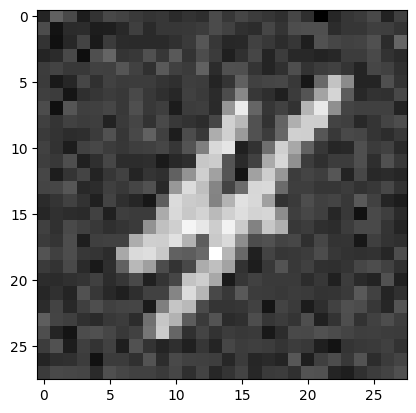

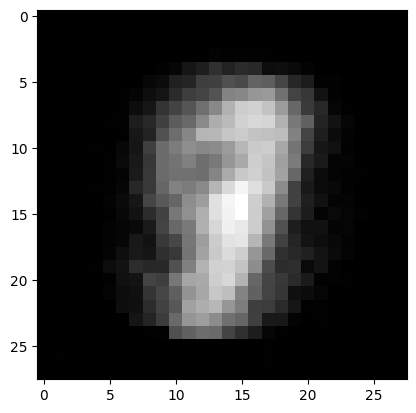

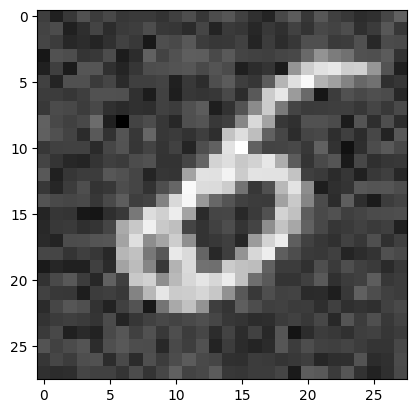

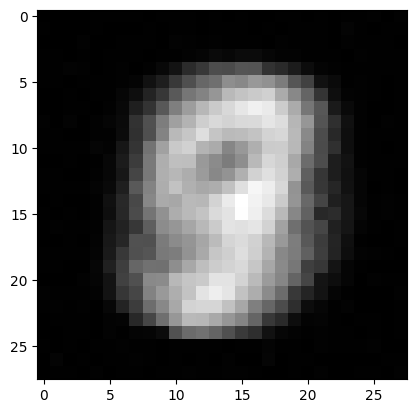

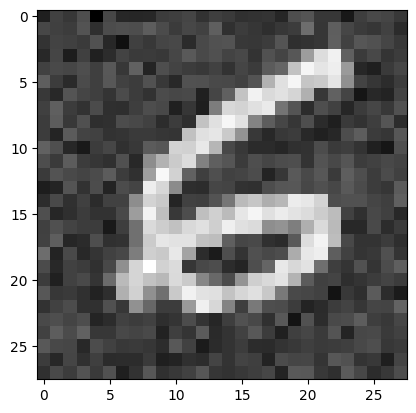

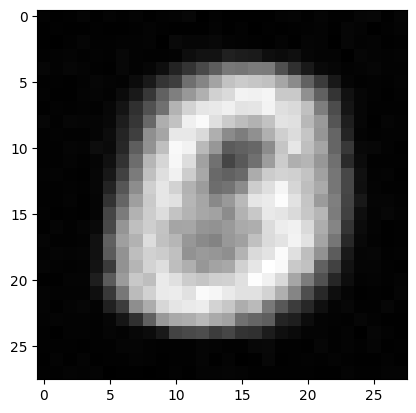

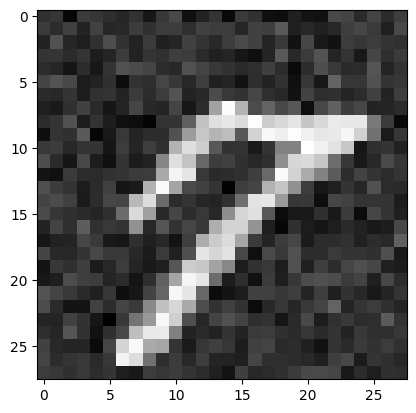

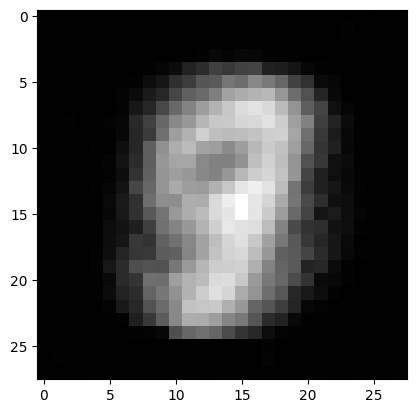

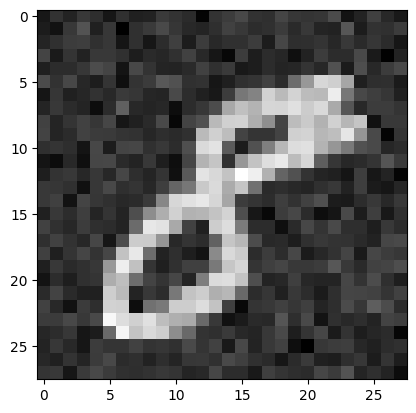

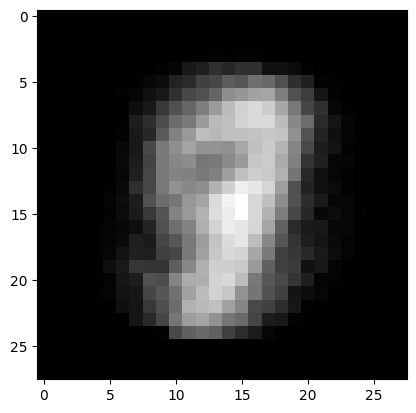

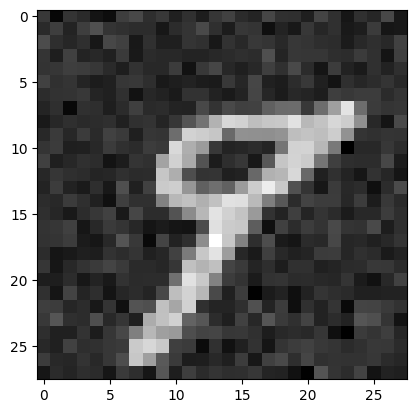

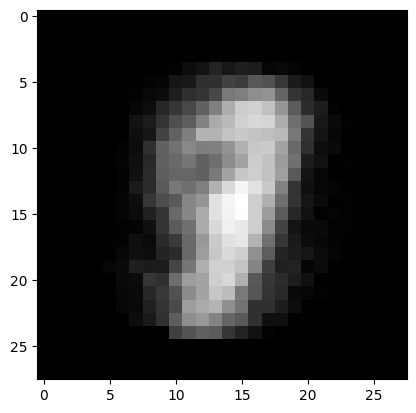

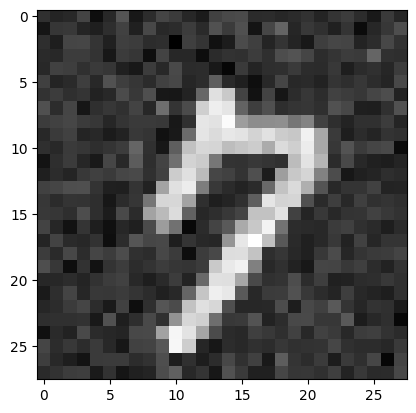

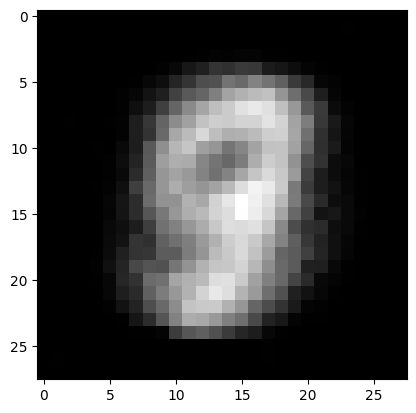

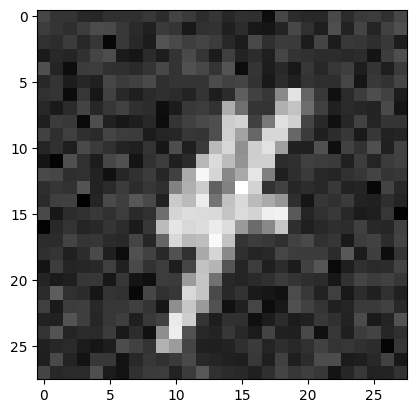

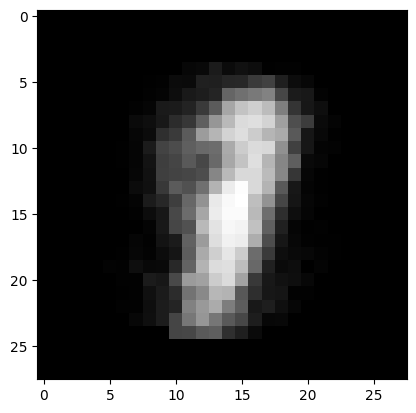

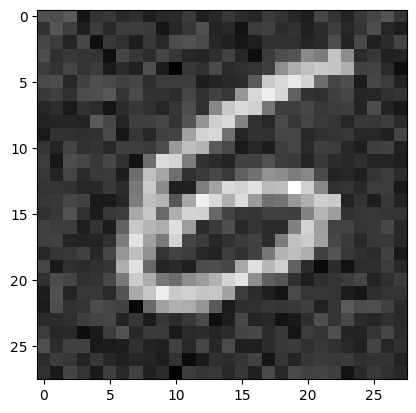

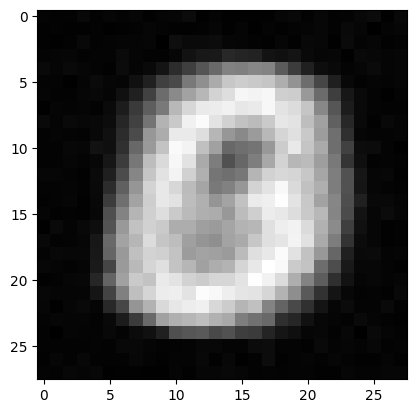

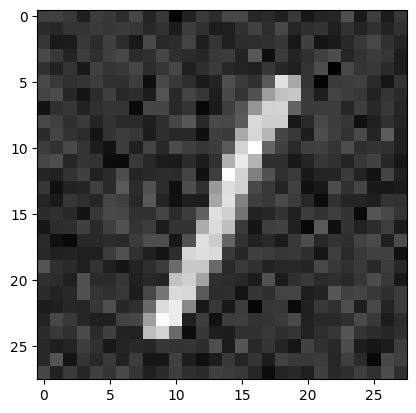

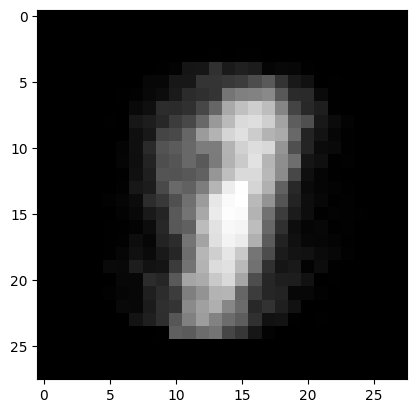

In [9]:
# 결과 확인
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(10):
    plt.imshow(torch.squeeze(image[i].cpu()).numpy(), cmap='gray')
    plt.show()
    plt.imshow(out_img[i].cpu().numpy(), cmap='gray')
    plt.show()